<a href="https://colab.research.google.com/github/aniruddh-shukla/ATML-proj/blob/main/NaiveBayesEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade sklearn

Requirement already up-to-date: sklearn in /usr/local/lib/python3.7/dist-packages (0.0)


In [2]:
import numpy as np

from copy import deepcopy
from scipy.sparse import csr_matrix, vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from scipy.linalg import get_blas_funcs
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

class Semi_EM_MultinomialNB():
    """
    Naive Bayes classifier for multinomial models for semi-supervised learning.
    
    Use both labeled and unlabeled data to train NB classifier, update parameters
    using unlabeled data, and all data to evaluate performance of classifier. Optimize
    classifier using Expectation-Maximization algorithm.
    """
    def __init__(self, alpha=1.0, fit_prior=True, class_prior=None, max_iter=30, tol=1e-6, print_log_lkh=True):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior
        self.clf = MultinomialNB(alpha=self.alpha, fit_prior=self.fit_prior, class_prior=self.class_prior)
        self.log_lkh = -np.inf # log likelihood
        self.max_iter = max_iter # max number of EM iterations
        self.tol = tol # tolerance of log likelihood increment
        self.feature_log_prob_ = np.array([]) # Empirical log probability of features given a class, P(x_i|y).
        self.coef_ = np.array([]) # Mirrors feature_log_prob_ for interpreting MultinomialNB as a linear model.
        self.print_log_lkh = print_log_lkh # if True, print log likelihood during EM iterations

    def fit(self, X_l, y_l, X_u):
        """
        Initialize the parameter using labeled data only.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.fit(X_l, y_l) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T.toarray()]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T.toarray()) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        if self.print_log_lkh:
            print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            if self.print_log_lkh:
                print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose().toarray()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose().toarray()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            if self.print_log_lkh:
                print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def fit_with_clustering(self, X_l, y_l, X_u, y_u=None):
        """
        Initialize the parameter using both labeled and unlabeled data.
        The classes of unlabeled data are assigned using similarity with labeled data.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        The label propagation can only use dense matrix, so it is quite time consuming.
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs): 
        # assign class to unlabeled data using similarity with labeled data if y_u is not given
        if (y_u==None):
            label_prop_model = LabelSpreading(kernel='rbf', max_iter=5, n_jobs=-1)
            y_u = np.array([-1.0]*n_ul_docs)
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            label_prop_model.fit(X.toarray(), y)
            y_u = label_prop_model.predict(X_u.toarray())
        y = np.concatenate((y_l, y_u), axis=0)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.fit(X, y) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T.toarray()]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T.toarray()) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        if self.print_log_lkh:
            print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            if self.print_log_lkh:
                print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose().toarray()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose().toarray()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            if self.print_log_lkh:
                print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def partial_fit(self, X_l, y_l, X_u=np.array([])):
        """
        Initialize the parameter using labeled data only.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        This function can only be used after fit()
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.partial_fit(X_l, y_l) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T.toarray()]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T.toarray()) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.partial_fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose().toarray()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose().toarray()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, X, y):
        return self.clf.score(X, y)

    def get_params(deep=True):
        return self.clf.get_params(deep)

    def __str__(self):
        return self.clf.__str__()

In [3]:
# Import packages and libraries
import numpy as np
import random as rnd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
#from Semi_EM_NB import Semi_EM_MultinomialNB
from os import path
from PIL import Image

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [5]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_scores = list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    avg_accuracy = 0
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        scores = dict()
        scores['accuracy'] = metrics.accuracy_score(valid_y, pred)
        scores['recall'] = metrics.recall_score(valid_y, pred, average='macro')
        scores['precision'] = metrics.precision_score(valid_y, pred, average='macro')
        scores['f1_score'] = metrics.f1_score(valid_y, pred, average='macro')
        train_scores.append(scores)
        avg_accuracy += scores['accuracy']
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % (avg_accuracy/n_folds))
    return train_scores, train_time

In [6]:
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 5, 4
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    #d = path.dirname(__file__)
    circle_mask = np.array(Image.open(path.join('./', "circle.png")))
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(background_color="white", mask=circle_mask).generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()

In [7]:
# Load data set with class labels and split into train and test set
test_size_ratio = 0.2
data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = data_Xy.target_names # text names of all categories
train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:    15076	Test set size:     3770


In [8]:
# preprocess train and test text data
train_X_clean = map(remove_noise, train_X)
test_X_clean = map(remove_noise, test_X)

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_X_clean)
test_vec = vectorizer.transform(test_X_clean)
print (train_vec.shape, test_vec.shape)

(15076, 13114) (3770, 13114)


In [11]:
# Divide train data set into labeled and unlabeled data sets
split_ratio = 0.2 # labeled vs total(labeled+unlabeled)
# X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, train_size=split_ratio, stratify=train_y)
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, test_size=10000, stratify=train_y)
experiments = np.logspace(2.3, 3.7, num=20, base=10, dtype='int')
print (X_l.shape, X_u.shape)

(5076, 13114) (10000, 13114)


In [12]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_cv_scores = list()
nb_cv_times = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2)
    cv_scores, cv_time = cross_validation(nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs])
    nb_cv_scores.append(cv_scores)
    nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.074 seconds
Average training accuracy: 0.387
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.081 seconds
Average training accuracy: 0.411
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

Fold # 4
Fold # 5
Validation time: 0.093 seconds
Average training accuracy: 0.457
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.077 seconds
Average training accuracy: 0.462
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.091 seconds
Average training accuracy: 0.473
Number of labeled documents:    393
Validation: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr


MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.087 seconds
Average training accuracy: 0.485
Number of labeled documents:    466
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.087 seconds
Average training accuracy: 0.518
Number of labeled documents:    552
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

Fold # 3
Fold # 4
Fold # 5
Validation time: 0.094 seconds
Average training accuracy: 0.531
Number of labeled documents:    654
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.091 seconds
Average training accuracy: 0.543
Number of labeled documents:    775
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

Fold # 4
Fold # 5
Validation time: 0.101 seconds
Average training accuracy: 0.571
Number of labeled documents:    918
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.082 seconds
Average training accuracy: 0.589
Number of labeled documents:   1088
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5
Validation time: 0.103 seconds
Average training accuracy: 0.597
Number of labeled documents:   1289
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.093 seconds
Average training accuracy: 0.603
Number of labeled documents:   1528
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.109 seconds
Average training accuracy: 0.620
Number of labeled documents:   1810
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.098 seconds
Average training accuracy: 0.639
Number of labeled documents:   2145
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.108 seconds
Average training accuracy: 0.654
Number of labeled documents:   2542
Validation: 
Multin

In [13]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_cv_scores = list()
em_nb_cv_times = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
    cv_scores, cv_time = cross_validation(em_nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    em_nb_cv_scores.append(cv_scores)
    em_nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 46.401 seconds
Average training accuracy: 0.432
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 45.530 seconds
Average training accuracy: 0.449
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 43.304 seconds
Average training accuracy: 0.521
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 38.632 seconds
Average training accuracy: 0.544
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 40.437 seconds
Average training accuracy: 0.560
Number of labeled documents:    393
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 43.127 seconds
Average training accuracy: 0.590
Number of labeled documents:    466
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 38.944 seconds
Average training accuracy: 0.576
Number of labeled documents:    552
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 34.649 seconds
Average training accuracy: 0.589
Number of labeled documents:    654
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2
Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 35.540 seconds
Average training accuracy: 0.603
Number of labeled documents:    775
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2
Fold # 3
Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5
Validation time: 32.902 seconds
Average training accuracy: 0.619
Number of labeled documents:    918
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 2
Fold # 3
Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5
Validation time: 31.596 seconds
Average training accuracy: 0.631
Number of labeled documents:   1088
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4
Fold # 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation time: 30.398 seconds
Average training accuracy: 0.639
Number of labeled documents:   1289
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 28.313 seconds
Average training accuracy: 0.652
Number of labeled documents:   1528
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 27.824 seconds
Average training accuracy: 0.666
Number of labeled documents:   1810
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 27.336 seconds
Average training accuracy: 0.667
Number of labeled documents:   2145
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3
Fold # 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 5
Validation time: 26.691 seconds
Average training accuracy: 0.677
Number of labeled documents:   2542
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 4
Fold # 5
Validation time: 29.575 seconds
Average training accuracy: 0.679
Number of labeled documents:   3012
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 24.600 seconds
Average training accuracy: 0.688
Number of labeled documents:   3569
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 25.680 seconds
Average training accuracy: 0.696
Number of labeled documents:   4229
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 23.638 seconds
Average training accuracy: 0.702
Number of labeled documents:   5011


Text(0.5, 1.0, 'Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

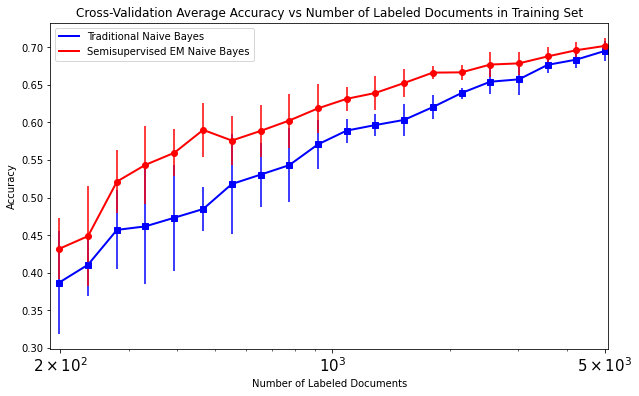

In [14]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['accuracy'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['accuracy'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')